In [1]:
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import OrderedDict
import math

srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(T.dot(X, w_h))

    h = dropout(h, p_drop_hidden)
    h2 = rectify(T.dot(h, w_h2))

    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

In [2]:
personasFolder = "../Personas/Artist/"
personasFname = personasFolder + "Khandhasamy/age_0.txt"
with open(personasFname) as f:
    personasContent = f.readlines()

currSec = ''
dnaName = ''
currTabCount = 0
prevTabCount = 0
personaMap = {}
keyInTabCount = {}
for l in range(len(personasContent)):
    #personaLine = [x.strip() for x in personasContent[l].split(':')]
    personaLine = personasContent[l].split(':')
    currTabCount = (len(personaLine[0]) - len(personaLine[0].lstrip(' ')))/4
    
    frac, whole = math.modf(2.5)
    
    if (frac > 0.0):
        if len(personaLine) == 2:
            currKey = personaLine[0].lstrip(' ').rstrip()
            currValue = personaLine[1].lstrip(' ').rstrip()

            if (len(currKey) > 0 ):
                if (currTabCount > prevTabCount):
                    key = keyInTabCount[prevTabCount] + "_" + currKey
                    #personaMap[key] = currValue
                elif (currTabCount < prevTabCount):
                    if currTabCount == 0:
                        keyTabCount = 0
                    else:
                        keyTabCount = currTabCount - 1
                    if currTabCount == 0:
                        key = currKey
                    else:
                        key = keyInTabCount[keyTabCount] + "_" + currKey
                    #personaMap[key] = currValue
                else:    
                    if currTabCount == 0:
                        keyTabCount = 0
                    else:
                        keyTabCount = currTabCount - 1;
                    if currTabCount == 0:
                        key = currKey
                    else:
                        key = keyInTabCount[keyTabCount] + "_" + currKey
                personaMap[key] = currValue 
                keyInTabCount[currTabCount] = key 
                prevTabCount = currTabCount
    else:
        print ('invalid spacing in the persona definition \n')
    
    """
    if personaLine[0] == 'DNA':
        currSec = personaLine[0]
        dnaName = personaLine[1]
        continue
    if personaLine[0] == 'Physical':
        currSec = personaLine[0]
        continue
    if currSec == 'DNA':
        print (personaLine[1]) 
        personaMap[personaLine[0]] = personaLine[1]
    """
personaMap

{'Age': '0',
 'Age_LearningCycle': '0',
 'Age_train': '',
 'Age_train_input': '',
 'Age_train_input_information': '/trainImages',
 'Age_train_input_transform': 'imageTransform',
 'Age_train_input_transform_color': 'grey',
 'Age_train_output': '',
 'Age_train_output_information': '/trainImages',
 'Age_train_output_transform': 'imageTransform',
 'Age_train_output_transform_color': 'RGB',
 'Age_train_output_transform_height': '200',
 'Age_train_output_transform_width': '200',
 'DNA': 'Khandhasamy',
 'DNA_LayerX1': '400',
 'DNA_LayerX2': '200',
 'DNA_input': '40000',
 'DNA_input_information': '/testImages',
 'DNA_input_transform': 'imageTransfrom',
 'DNA_input_transform_color': 'grey',
 'DNA_input_transform_height': '200',
 'DNA_input_transform_width': '200',
 'DNA_output': '40000',
 'Environment': '',
 'Environment_information': 'portraits',
 'Environment_society': 'none',
 'Physical': 'Theano'}

In [3]:
#DNA declaration handling
dnaMap = OrderedDict()
currSec = ''
if 'DNA' in personaMap:
    dnaFileName = "../DNA/Family/" + personaMap['DNA'] + ".txt"
    with open(dnaFileName) as f:
        dnaContents = f.readlines()

for l in range(len(dnaContents)):
    dnaList = [x.strip() for x in dnaContents[l].split(',')]
    #dnaList = dnaContents[l].split(",")
    for d in range(len(dnaList)):
        dnaComponentName = "DNA_"+ dnaList[d].replace('[','').replace(']','')
        if ";" in dnaComponentName:
            dnaComponentName = dnaComponentName.replace("DNA_", "")
            if "+" in dnaComponentName:
                dnaComponentName = dnaComponentName.replace('+','')
                subDNAList = ["DNA_" + x.strip() for x in dnaComponentName.split(';')]
                dnaMap['subDNA_N'] = subDNAList
            else:
                subDNAList = [x.strip() for x in dnaComponentName.split(';')]
                dnaMap['subDNA_1'] = subDNAList
        else:
            dnaMap[dnaComponentName] = ''
dnaMap

OrderedDict([('DNA_input', ''),
             ('DNA_FullyConnected', ''),
             ('subDNA_N',
              ['DNA_LayerX1', 'DNA_FullyConnected', 'DNA_LayerX2']),
             ('DNA_output', '')])

In [11]:
physicalOutputFileName = "output.py"
#to generate code for call model function 
modelString = "y_x = model("
paramString = "params = ["
modelFunc = "def model("
modelFuncContent = ""
inpOutMatrixContent = ""
prevLayerName = ""

with open(physicalOutputFileName, 'w') as f:
    #generate code for imports
    f.write('import theano \n')
    f.write('from theano import tensor as T \n')
    f.write('from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams \n')
    f.write('import numpy as np \n')
    f.write('import matplotlib.pyplot as plt \n')
    f.write('import matplotlib.cm as cm \n')
    f.write('\n')

    weightLayer = 1
    weightLayerValue = []
    for dnaComponentName, dnaSubComponentName in dnaMap.items(): 
        #generate code for input components
        if dnaComponentName == 'DNA_input':
            #generate input matrix 
            inpOutMatrixContent += "X = T.fmatrix() \n"
            modelString += "X,"
            modelFunc += "X,"
            #generate code for dropout in model function (is it specified in DNA or persona?)
            modelFuncContent += "    X = dropout(X, p_drop_input) \n"
            #remember previous layer name
            prevLayerName = "X"
            #get number of neurons for input layer from persona definition
            weightLayerValue.append(personaMap[dnaComponentName])
            #if weight layer value is 2 means, destination layer found 
            if len(weightLayerValue) == 2:
                #generate layer name (w_h1, w_h2 ... etc)
                weightLayerName = 'w_h' + str(weightLayer)
                #generate code for weight initialization (consider input dimension, right now coded for 2 dimension)
                f.write(weightLayerName + ' = init_weights(('+weightLayerValue[0]+', '+weightLayerValue[1]+')) \n')
                #increase weight layer name
                weightLayer += 1
                #remove previous layer value (always weightLayerValue will be <=2)
                weightLayerValue.pop(0)
                #update call model function for new weight layer
                modelString += weightLayerName + ","
                #update param string which is used for update function
                paramString += weightLayerName + ","
                #update model function name to add layer name
                modelFunc += weightLayerName + ","    
        #if sub DNA structure handling
        if "subDNA" in dnaComponentName:
            #iterate over each sub DNA component
            for s in range(len(dnaSubComponentName)):
                #if layer name found (i.e LayerX)
                if 'LayerX' in dnaSubComponentName[s]:
                    #generate code for previous layer output rectification (this has to be in DNA or persona definition?)
                    modelFuncContent += "    w_o_h" +str(weightLayer)+ "=rectify(T.dot("+prevLayerName+", "+"w_h" + str(weightLayer)+")) \n"
                    #generate code for current layer dropout (this has to be in DNA or persona definition?)
                    modelFuncContent += "    w_o_h" +str(weightLayer) + "= dropout(w_o_h"+str(weightLayer)+", p_drop_input) \n"
                    #change previous layer name to current
                    prevLayerName = 'w_o_h' + str(weightLayer)
                    #new layer identified and store this layer no. of neurons
                    weightLayerValue.append(personaMap[dnaSubComponentName[s]])
                    #if within sub DNA structure, if destionation layer found (if its equals 2)
                    if len(weightLayerValue) == 2:
                        #generate layer name
                        weightLayerName = 'w_h' + str(weightLayer)
                        #generate code to initialize weights for current layer (right now its 2 dimension, has to be flexible for any dimension?)
                        f.write(weightLayerName + ' = init_weights(('+weightLayerValue[0]+', '+weightLayerValue[1]+')) \n')
                        #increase layer name 
                        weightLayer += 1
                        #remove previous layer from the weight layer array as we have generated code for that
                        weightLayerValue.pop(0)
                        #update call model function for new layer name
                        modelString += weightLayerName + ","
                        #update params for new weight layer name
                        paramString += weightLayerName + ","
                        #update model function name
                        modelFunc += weightLayerName + ","
                                            
        if dnaComponentName == 'DNA_output': 
            #generate code for output matrix
            inpOutMatrixContent += "Y = T.fmatrix() \n"
            
            #generate code for final output layer (right now its softmax, is this from DNA or persona definition?)
            modelFuncContent += "    y_x = softmax(T.dot("+prevLayerName+", "+'w_h' + str(weightLayer)+")) \n"
            #update previous layer name with current layer
            prevLayerName = 'w_h' + str(weightLayer)
            #append new layer's no. of neurons
            weightLayerValue.append(personaMap[dnaComponentName])
            
            if len(weightLayerValue) == 2:
                weightLayerName = 'w_h' + str(weightLayer)
                f.write(weightLayerName + ' = init_weights(('+weightLayerValue[0]+', '+weightLayerValue[1]+')) \n')
                weightLayer += 1
                weightLayerValue.pop(0)
                #update call model function for new weight layer name (enhance?)
                modelString += weightLayerName + ")"
                #udpate params for new weight layer name which is used it for updates (enhance?)
                paramString += weightLayerName + "]"
                #update model function name to pass new weight layer
                modelFunc += weightLayerName + ","
    
    #generate model function name with weight params (is this possible to generalize this for all params?)
    modelFunc = modelFunc + "p_drop_input, p_drop_hidden):"
    
    #generate code for model function body
    f.write( "\n" + modelFunc +  '\n')
    f.write( modelFuncContent +  '    return y_x \n')
    f.write('\n')

    #generate code for input, output matix definition
    f.write( "\n" + inpOutMatrixContent +  '\n')
    
    f.write(modelString +  '\n')
    f.write( "cost = T.mean(T.nnet.categorical_crossentropy(y_x, Y))" +  '\n')
    
    #generate code for updates (is that possible to generalize this update function for all scenatios?)
    f.write( paramString +  '\n')
    f.write("updates = RMSprop(cost, params, lr=0.001) \n")
    
    f.write("train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True) \n")
    f.write("predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True) \n")
    f.write('\n')
    
    #drop out function definition (is this could me moved and used with import?)
    f.write("def dropout(X, p=0.): \n")
    f.write("    if p > 0: \n")
    f.write("    retain_prob = 1 - p \n")
    f.write("    X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX) \n")
    f.write("    X /= retain_prob \n")
    f.write("    return X \n")
    f.write('\n')

    #rectification (could be sepeated in other files and imported?)
    f.write("def rectify(X): \n")
    f.write("    return T.maximum(X, 0.) \n")
    f.write('\n')

    #softmax function (could be imported?)
    f.write("def softmax(X): \n")
    f.write("    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x')) \n")
    f.write("    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x') \n")
    f.write('\n')

    #float array definition (could be imported?)
    f.write("def floatX(X): \n")
    f.write("    return np.asarray(X, dtype=theano.config.floatX) \n")
    f.write('\n')

    #initialize weights (could be imported?)
    f.write("def init_weights(shape): \n")
    f.write("    return theano.shared(floatX(np.random.randn(*shape) * 0.01)) \n")
    f.write('\n')

    #update function for learning (could be imported?)
    f.write("def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6): \n")
    f.write("    grads = T.grad(cost=cost, wrt=params) \n")
    f.write("    updates = [] \n")
    f.write("    for p, g in zip(params, grads): \n")
    f.write("        acc = theano.shared(p.get_value() * 0.) \n")
    f.write("        acc_new = rho * acc + (1 - rho) * g ** 2 \n")
    f.write("        gradient_scaling = T.sqrt(acc_new + epsilon) \n")
    f.write("        g = g / gradient_scaling \n")
    f.write("        updates.append((acc, acc_new)) \n")
    f.write("        updates.append((p, p - lr * g)) \n")
    f.write("    return updates \n")
    f.write('\n')



In [ ]:
transformFolder = "../Environment/Informations/Transformations/"
transformFolder = transformFolder + "Khandhasamy/age_0.txt"
with open(personasFname) as f:
    personasContent = f.readlines()
    
with open(physicalOutputFileName, 'w') as f:

In [548]:
with open(fname) as f:
    content = f.readlines()
trX, teX, trY, teY = mnist(onehot=True)

X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((80000, 784))
w_h2 = init_weights((784, 784))
w_o = init_weights((784, 400))

noise_h, noise_h2, noise_py_x = model(X, w_h, w_h2, w_o, 0.2, 0.5)
h, h2, py_x = model(X, w_h, w_h2, w_o, 0., 0.)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

predictImg = theano.function(inputs=[X], outputs=py_x, allow_input_downcast=True)


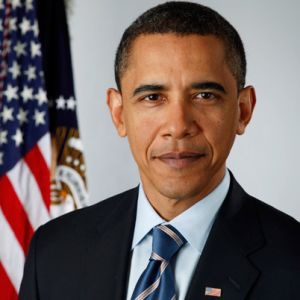

In [549]:
import PIL
from PIL import Image
img = Image.open("images\obama.jpg")
grayImg = img.convert('L')
bwImg =  grayImg.convert('1', dither=Image.NONE) 
img

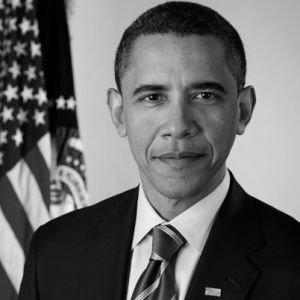

In [550]:
grayImg

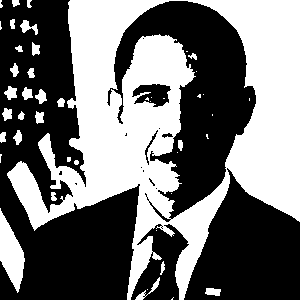

In [551]:
bwImg

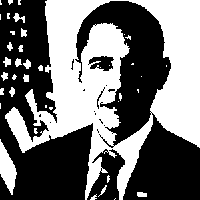

In [552]:
bwImg = bwImg.resize((200,200), PIL.Image.ANTIALIAS)
bwImg

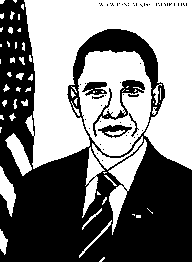

In [553]:
cartoonImg = Image.open("images\cartoon.jpg")
grayImg = cartoonImg.convert('L')
cartoonBwImg =  grayImg.convert('1', dither=Image.NONE) 
cartoonBwImg

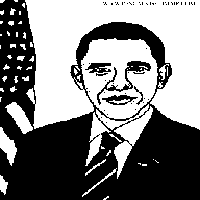

In [554]:
cartoonBwImg = cartoonBwImg.resize((200,200), PIL.Image.ANTIALIAS)
cartoonBwImg

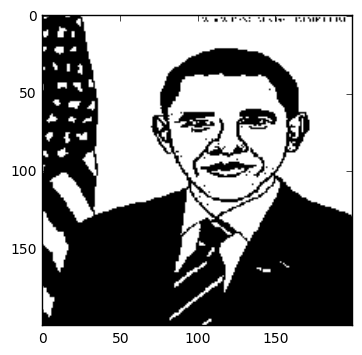

In [555]:
bwImgArray = np.asarray(bwImg, dtype=np.uint8).ravel()
cartoonImgArray = np.asarray(cartoonBwImg, dtype=np.uint8).ravel()
plt.imshow(cartoonImgArray.reshape(200,200), cmap = cm.Greys_r)
plt.show()

In [556]:
predImgArray = predictImg([np.append(bwImgArray,bwImgArray)])
predImg2dArray = predImgArray[0].reshape(200,200)

pImg = Image.fromarray(predImg2dArray,'L')

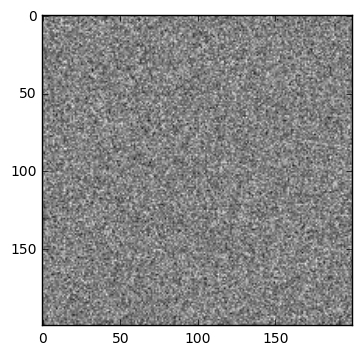

In [557]:
plt.imshow(predImg2dArray, cmap = cm.Greys_r)
plt.show()

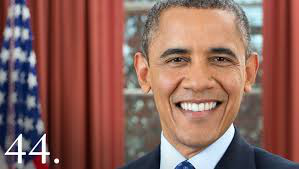

In [558]:
img = Image.open("images\laugh.jpg")
grayImg = img.convert('L')
bwImg =  grayImg.convert('1', dither=Image.NONE) 
img

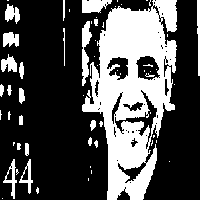

In [559]:
bwImg = bwImg.resize((200,200), PIL.Image.ANTIALIAS)
bwImg

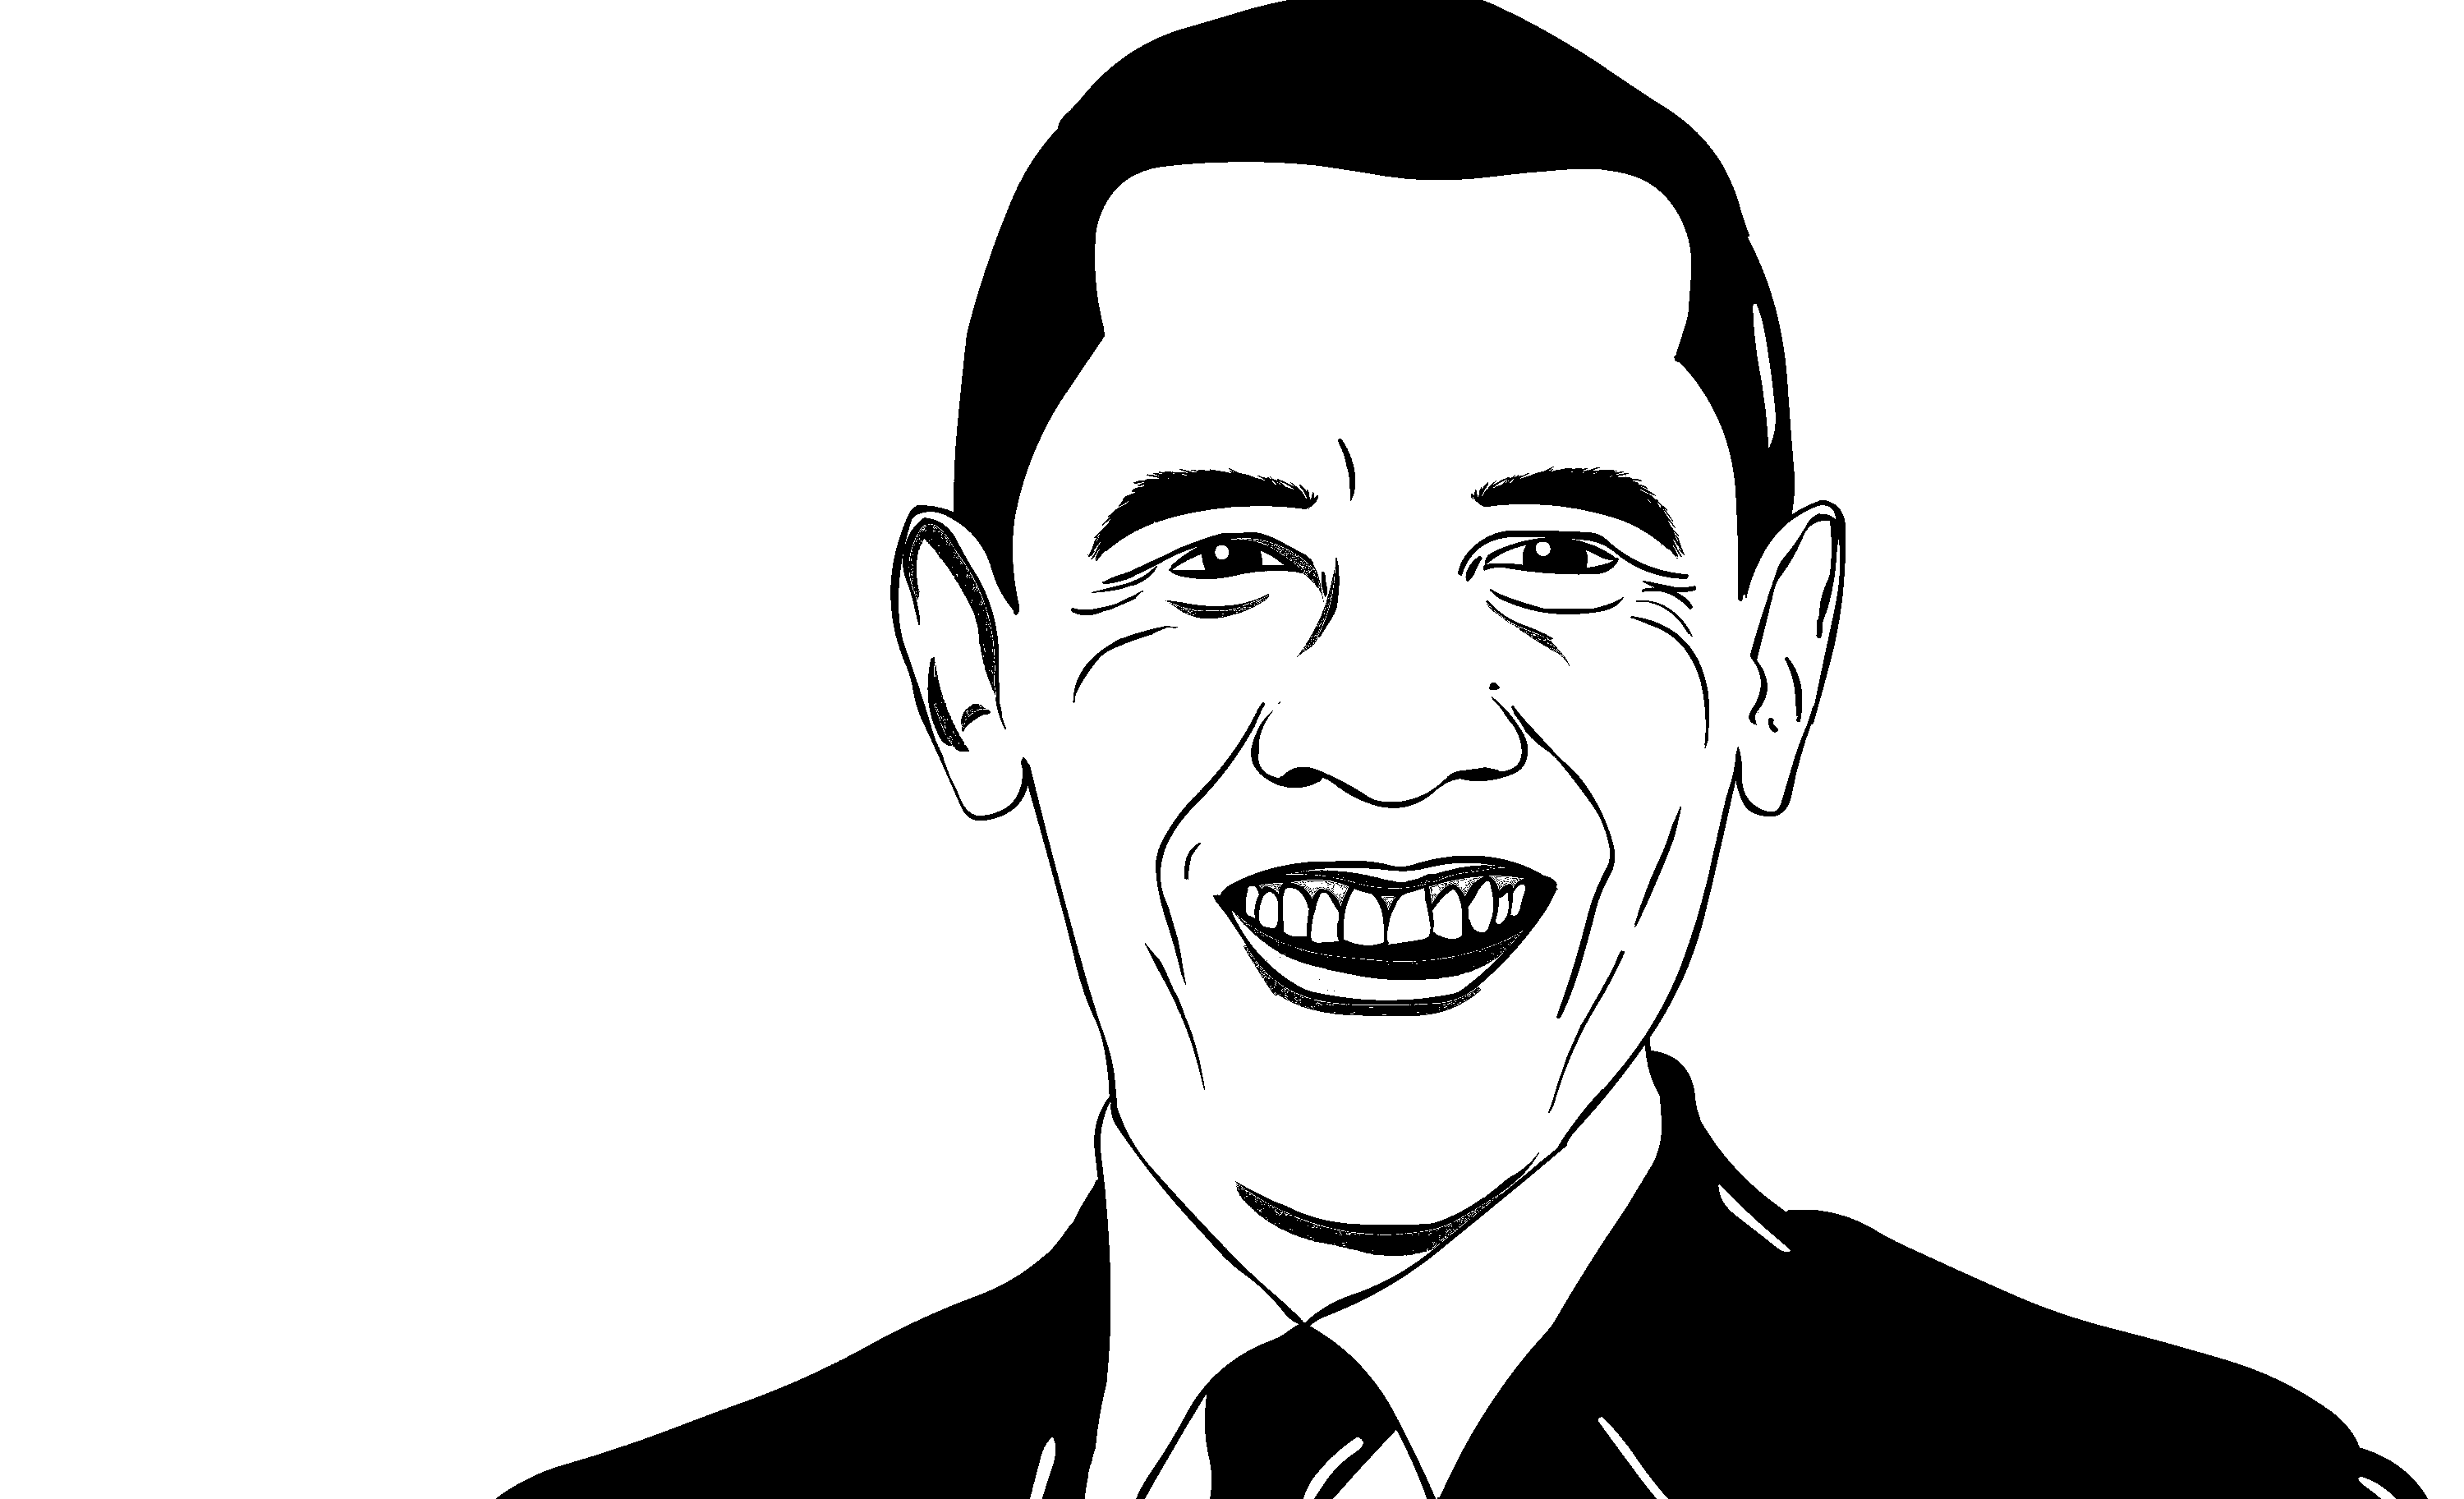

In [560]:
cartoonImg = Image.open("images\lcartoon.jpg")
grayImg = cartoonImg.convert('L')
cartoonBwImg =  grayImg.convert('1', dither=Image.NONE) 
cartoonBwImg

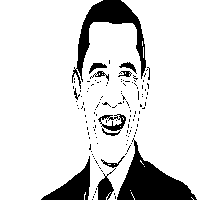

In [561]:
cartoonBwImg = cartoonBwImg.resize((200,200), PIL.Image.ANTIALIAS)
cartoonBwImg

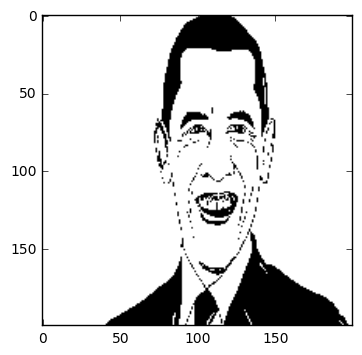

In [562]:
bwImgArray = np.asarray(bwImg, dtype=np.uint8).ravel()
cartoonImgArray = np.asarray(cartoonBwImg, dtype=np.uint8).ravel()
plt.imshow(cartoonImgArray.reshape(200,200), cmap = cm.Greys_r)
plt.show()

In [563]:
m = np.append(bwImgArray, bwImgArray)
len(m)

80000

In [564]:
predImgArray = predictImg([np.append(bwImgArray, bwImgArray)])
predImg2dArray = predImgArray[0].reshape(200,200)

pImg = Image.fromarray(predImg2dArray,'L')

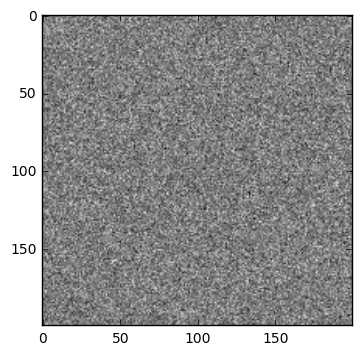

In [565]:
plt.imshow(predImg2dArray, cmap = cm.Greys_r)
plt.show()

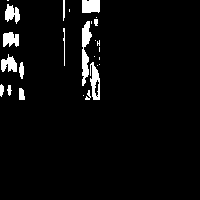

In [566]:
old_im = Image.open('images\laugh.jpg')
grayImg = old_im.convert('L')
bwImg =  grayImg.convert('1', dither=Image.NONE) 
bwImg = bwImg.resize((200,200), PIL.Image.ANTIALIAS)
cropImg = bwImg.crop((0, 0, 100, 100))
new_im = Image.new("L", (200,200))
new_im.paste(cropImg, box=(0,0))
new_im

In [567]:
predImgArray1 = np.zeros(40000)
predImgArray2 = np.zeros(40000)
for i in range(10):
    part_img_x = 0
    part_img_y = 0
    for p in range(10): 
        
        img = Image.open("images\laugh.jpg")
        grayImg = img.convert('L')
        bwImg =  grayImg.convert('1', dither=Image.NONE)
        bwImg = bwImg.resize((200,200), PIL.Image.ANTIALIAS)
        bwImgArray = np.asarray(bwImg, dtype=np.uint8).ravel()
        
        cartoonImg = Image.open("images\lcartoon.jpg")
        grayImg = cartoonImg.convert('L')
        cartoonBwImg =  grayImg.convert('1', dither=Image.NONE) 
        cartoonBwImg = cartoonBwImg.resize((200,200), PIL.Image.ANTIALIAS)
        cartoonImgArray = np.asarray(cartoonBwImg, dtype=np.uint8).ravel()
 
        cropImg = bwImg.crop((0, 0, part_img_x*20, part_img_y*20))
        in_part_img = Image.new("L", (200,200))
        in_part_img.paste(cropImg, box=(0,0))
        inImgArray = np.asarray(in_part_img, dtype=np.uint8).ravel()

        cropImg = cartoonBwImg.crop((0, 0, part_img_x*20, part_img_y*20))
        out_part_img = Image.new("L", (20,20))
        out_part_img.paste(cropImg, box=(0,0))  
        outImgArray = np.asarray(out_part_img, dtype=np.uint8).ravel()
        
        cost = train([np.append(bwImgArray,predImgArray1)], [outImgArray])
        
        predImgArray = predictImg([np.append(bwImgArray,predImgArray1)])
        
        part_img_x += 1
        part_img_y += 1

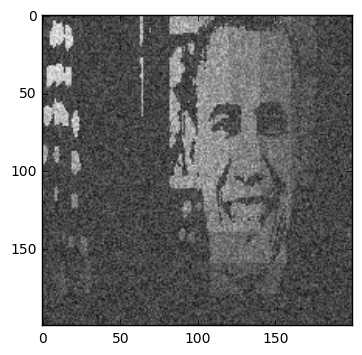

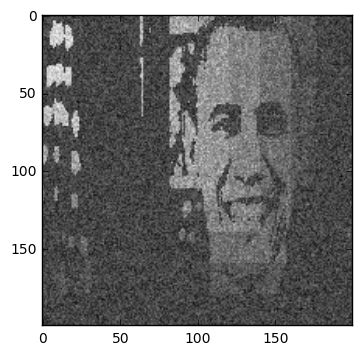

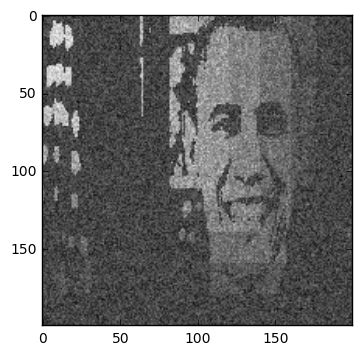

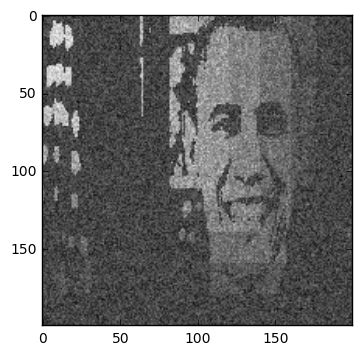

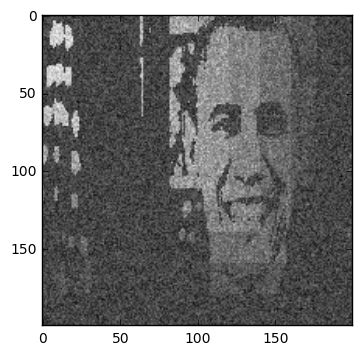

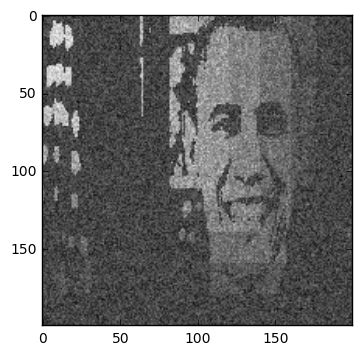

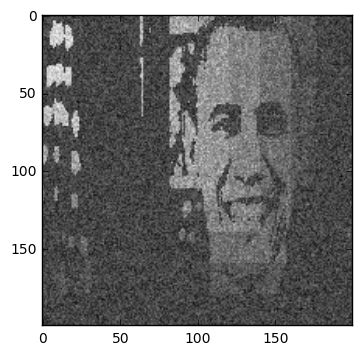

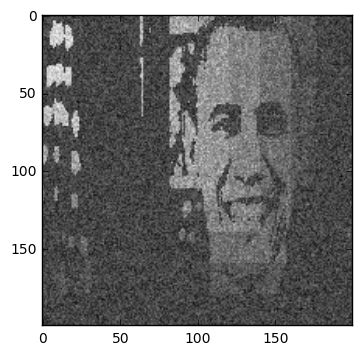

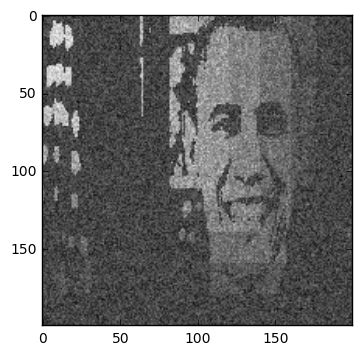

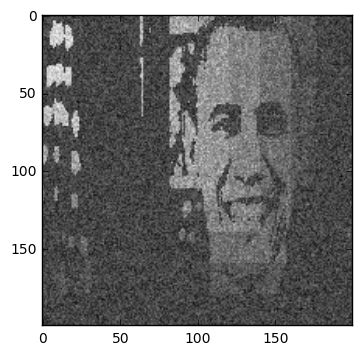

In [568]:
predImgArray1 = np.zeros(40000)
for i in range(10):
    img = Image.open("images\laugh.jpg")
    grayImg = img.convert('L')
    bwImg =  grayImg.convert('1', dither=Image.NONE) 
    bwImg = bwImg.resize((200,200), PIL.Image.ANTIALIAS)
    bwImgArray = np.asarray(bwImg, dtype=np.uint8).ravel()
    predImgArray = predictImg([np.append(bwImgArray,predImgArray1)])
    predImg2dArray = predImgArray[0].reshape(200,200)
    predImgArray1 = predImgArray[0]
    plt.imshow(predImg2dArray, cmap = cm.Greys_r)
    plt.show()

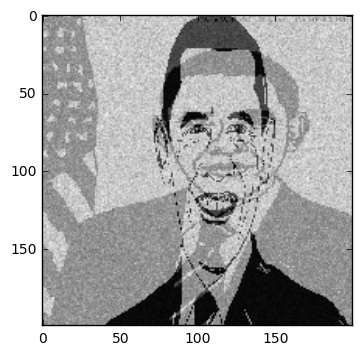

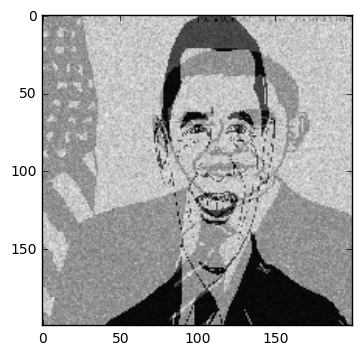

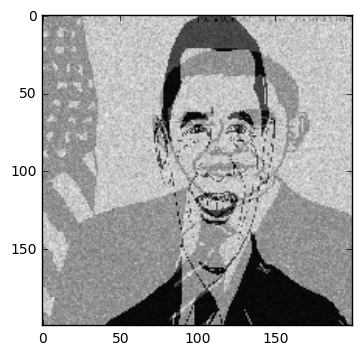

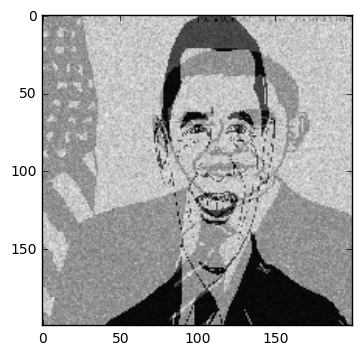

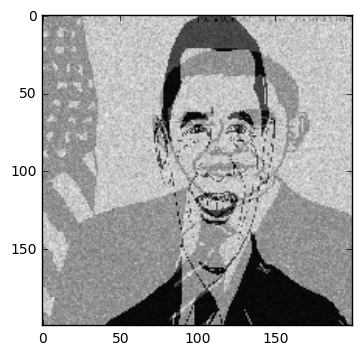

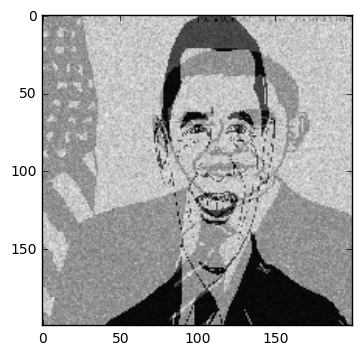

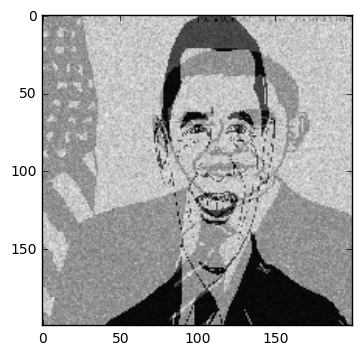

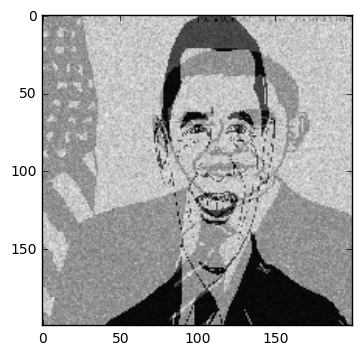

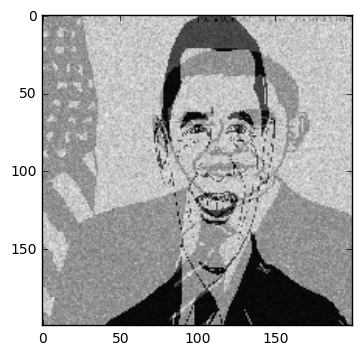

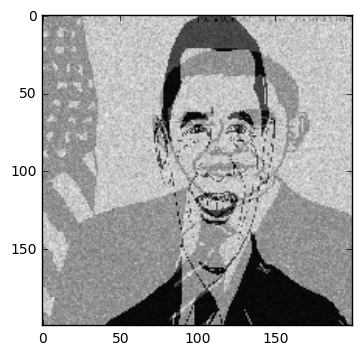

In [489]:
predImgArray2 = np.zeros(40000)
for i in range(10):
    img = Image.open("images\laugh.jpg")
    grayImg = img.convert('L')
    bwImg =  grayImg.convert('1', dither=Image.NONE) 
    bwImg = bwImg.resize((200,200), PIL.Image.ANTIALIAS)
    bwImgArray = np.asarray(bwImg, dtype=np.uint8).ravel()
    predImgArray = predictImg([np.append(bwImgArray,predImgArray2)])
    predImg2dArray = predImgArray[0].reshape(200,200)
    predImgArray2 = predImgArray[0]
    plt.imshow(predImg2dArray, cmap = cm.Greys_r)
    plt.show()